# <b>Moduel 2 - Peak Calling and Differential Analysis</b> 
--------------------------------------------

## Overview
In this module, we will cover the analysis of m6A MeRIP-seq data. We will focus on two key steps:
1. **Peak calling** to identify regions of the genome/transcriptome that are enriched in m6A methylation, using MeRIPtools.
2. **Differential methylation analysis** to detect changes in methylation between conditions, using exomePeak2 and RADAR.

We will guide you through how to use **MeRIPtools** to call peaks and then how to perform differential analysis with two workflows: **exomePeak2** and **RADAR**, highlighting key considerations for each tool.

## Learning Objectives
+ <b>Learning Objective 1</b>: Understand the distinction between peak calling and differential methylation analysis, their relationship, and the inputs/outputs required for each step. 
+ <b>Learning Objective 2</b>: Apply appropriate tools and workflows to perform these two steps.
    - Learning Objective **2.1** Perform peak calling using MeRIPtools and interpret the peak regions it identifies.
    - Learning Objective **2.2** Use RADAR for differential methylation analysis, focusing on the comparison between experimental conditions.
    - Learning Objective **2.3** Use exomePeak2 for integrated peak calling and differential methylation analysis, covering both steps in one workflow.
+ <b>Learning Objective 3</b>: Interpret and analyze the outputs from each tool. Compare the results across different workflows (MeRIPtools, RADAR, and exomePeak2) and understand how to integrate these results if necessary.

## Prerequisites
You will need the following files prepared in **Tutorial 1**:

- **Alignment Files (BAM format)**: These are the output files generated when the raw reads were aligned to the reference genome in Tutorial 1.
- **GTF Annotation File**: This file, which was downloaded from the storage bucket as described in Tutorial 1, provides gene annotations necessary for the peak calling and differential analysis steps.

Ensure both the BAM files and the GTF annotation file are accessible and ready for use in this module.

## Outline
- **Introduction** to Peak calling and differential methylation analysis in MeRIPseq data analysis
- **Getting started**
    1. Installing R packages
    2. Setting up directory structures
    3. Prepare the Example Dataset
- **Peak calling** using MeRIPtools
- **RADAR** workflow for differential methylation analysis
- **ExomePeak2** workflow for Peak calling + differential methylation analysis


---
## Introduction
Analyzing MeRIP-seq data consists of two key steps: peak calling and differential methylation analysis. Peak calling identifies the regions of the genome or transcriptome that are enriched in m6A modifications, providing insights into where m6A is likely to occur. Differential methylation analysis then compares these methylation levels across different experimental conditions (e.g., control vs. treatment) to identify regions with significant changes in m6A levels. By combining these two steps, researchers can map m6A-modified regions and uncover important regulatory changes in RNA methylation associated with biological processes or disease states.

<img src="images/2-introduction.png" width=800 />

## 1. Get Started
### 1.1. Installing R packages

Installation of pre-requisite R packages. May take ~30 minites.

In [ ]:
#Rsamtools, GenomicFeatures (>= 1.14.5), Rcpp, ggplot2, doParallel, foreach, gplots, RColorBrewer, RcppArmadillo
if (!require("BiocManager", quietly = TRUE)){
    install.packages("BiocManager")
    print(" --- Installation of BiocManager is done. ---")
}
BiocManager::install("Rsamtools")
print(" --- Installation of Rsamtools is done. ---")
BiocManager::install("GenomicFeatures")
print(" --- Installation of GenomicFeatures is done. ---")
BiocManager::install(c("DESeq2","qvalue","txdbmaker"))
print(" --- Installation of DESeq2 is done. ---")
install.packages(c("Rcpp","ggplot2","doParallel","foreach","gplots","RColorBrewer","RcppArmadillo","BH"))
print(" --- Installation is done. ---")

Install the R package from Github. The installation should takes a few minutes if all depends are installed. Installing depends may takes longer time. (20 mins)

In [ ]:
install.packages("devtools")
devtools::install_github("scottzijiezhang/RADAR")
library("RADAR")

In [3]:
library("RADAR")

<div style="border: 1px solid #659078; padding: 0px; border-radius: 4px;">
  <div style="background-color: #d4edda; padding: 5px; font-weight: bold;">
    <i class="fas fa-lightbulb" style="color: #0e4628;margin-right: 5px;"></i>
      <span style="color: #0e4628">Tips - Running Bash Commands in an R Notebook </span>
  </div>
  <p style="margin-left: 5px;">
In an R notebook, you can use the <code>system()</code> function to execute bash commands. However, by default, <code>system()</code> will run the command without printing the output to the notebook. To display the output, you need to capture it by adding the argument intern = TRUE. This captures the command’s output as an R character vector, which you can then print using <code>cat()</code> or another R function. </p>

  <div style="margin-left: 5px;">Here, we create a function <code>runCommand()</code> to run a bash command and capture its result:</div>

In [4]:
# Function to run a system command and print the output
runCommand <- function(cmd){
    output <- tryCatch({
        system(cmd, intern = TRUE)
    }, warning = function(w) {
        warning(paste("Warning while running command:", cmd, "\n", w))
        return(NULL)
    }, error = function(e) {
        stop(paste("Error while running command:", cmd, "\n", e))
    })
    
    if(length(output) > 0){
        cat(output, sep = "\n")
    }
}

### 1.2. Setting up directory structures

In [5]:
if (!file.exists("Tutorial_2")){
    dir.create(file.path("Tutorial_2"))
    dir.create(file.path("Tutorial_2/bam"))
    dir.create(file.path("Tutorial_2/RADAR"))
}
setwd(file.path("Tutorial_2"))

## 2. **MeRIPtools** - Peak Calling
Need to be added.

## 3. **RADAR** workflow - Differential Analysis

Prepare meta data and copy the alignemnt files from Tutorial one and rename them.

In [6]:
# Load metadata
meta <- read.csv(file="../Tutorial_1/meta.txt", sep="\t", header=TRUE)

# Replace spaces with dots in Sample_title and remove specific text from Group
meta$sample <- gsub(" ", ".", meta$Sample_title)
meta$group <- gsub("omental | Fallopian tube", "", meta$Group)

# Construct old and new file paths
meta$old_bam <- paste0("../Tutorial_1/STAR/subset_", meta$Run, "Aligned.sortedByCoord.out.bam")
meta$new_bam <- paste0("bam/", meta$group, "_", meta$sample, ".bam")

# Rename and move the files
for(i in 1:nrow(meta)) {
   runCommand(paste0("cp ", meta$old_bam[i], " ", meta$new_bam[i]))
}

# Store sample information for further usage
meta$sample <- paste0(meta$group, "_", meta$sample)

# View modified meta
head(meta)

,Sample_title,Sample_geo_accession,Run,Group,sample,group,old_bam,new_bam
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,2380 input,GSM3359924,SRR7763558,omental tumor,tumor_2380.input,tumor,../Tutorial_1/STAR/subset_SRR7763558Aligned.sortedByCoord.out.bam,bam/tumor_2380.input.bam
2,2343 input,GSM3359925,SRR7763559,omental tumor,tumor_2343.input,tumor,../Tutorial_1/STAR/subset_SRR7763559Aligned.sortedByCoord.out.bam,bam/tumor_2343.input.bam
3,2270 input,GSM3359926,SRR7763560,omental tumor,tumor_2270.input,tumor,../Tutorial_1/STAR/subset_SRR7763560Aligned.sortedByCoord.out.bam,bam/tumor_2270.input.bam
4,2261 input,GSM3359927,SRR7763561,omental tumor,tumor_2261.input,tumor,../Tutorial_1/STAR/subset_SRR7763561Aligned.sortedByCoord.out.bam,bam/tumor_2261.input.bam
5,2221 input,GSM3359928,SRR7763562,omental tumor,tumor_2221.input,tumor,../Tutorial_1/STAR/subset_SRR7763562Aligned.sortedByCoord.out.bam,bam/tumor_2221.input.bam
6,2186 input,GSM3359929,SRR7763563,omental tumor,tumor_2186.input,tumor,../Tutorial_1/STAR/subset_SRR7763563Aligned.sortedByCoord.out.bam,bam/tumor_2186.input.bam


In [ ]:
list.files("bam")
samplenames <- unique(sub("\\..*", "", list.files("bam")))
samplenames

In [ ]:
library("RADAR")
samplenames <- gsub(".input|.m6A-IP","",meta$sample)
RADAR <- countReads(samplenames = samplenames,
                    gtf = "../Tutorial_1/gencode.v46.pri.chr11.1.5M.gtf",
                    bamFolder = "bam",
                    outputDir =  "RADAR",
                    modification = "m6A-IP",
                    binSize = 50, 
                    strandToKeep = "opposite",
                    paired = TRUE,
                    threads = 4
)

saveRDS(RADAR, file = "RADAR/radar1.rds")

In [ ]:
radar_obj <- readRDS(file = "RADAR/radar1.rds")

radar_obj <- normalizeLibrary(radar_obj)
radar_obj <- adjustExprLevel(radar_obj)
variable(radar_obj) <- data.frame( Group = gsub("_.*","",colnames(radar_obj@norm.input)))
radar_obj <- filterBins(radar_obj,minCountsCutOff = 15)
radar_obj <- diffIP_parallel(radar_obj, thread = 8)
top_bins <- extractIP(radar_obj,filtered = T)[order(rowMeans( extractIP(radar_obj,filtered = T) ),decreasing = T)[1:1000],]
radar_obj <- reportResult(radar_obj, cutoff = 0.1, Beta_cutoff = 0.5, threads=16)
result.1 <- results(radar_obj)
saveRDS(radar_obj, file = "radar2.rds")

In [10]:
result.1

,chr,start,end,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,logFC,p_value
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,chr11,505862,506107,ENSG00000023191.17,0,-,505862,506107,0,2,"20,30","0,216",0.5165956,9.483633e-04
2,chr11,561295,561344,ENSG00000099849.15,0,+,561295,561344,0,1,50,0,-0.6189324,1.396519e-02
"ENSG00000142089.17,1045",chr11,320752,320851,ENSG00000142089.17,0,-,320752,320851,0,1,100,0,0.5699800,2.380550e-04
11,chr11,289695,289744,ENSG00000142102.16,0,+,289695,289744,0,1,50,0,-0.6263072,1.228727e-05
12,chr11,294839,294888,ENSG00000142102.16,0,+,294839,294888,0,1,50,0,-1.3437347,3.186233e-04
"ENSG00000174915.12,1101",chr11,459071,459170,ENSG00000174915.12,0,+,459071,459170,0,1,100,0,-1.2090879,1.258565e-05
13,chr11,491286,491335,ENSG00000174915.12,0,+,491286,491335,0,1,50,0,0.5273910,1.278189e-02
14,chr11,644414,644463,ENSG00000177030.19,0,-,644414,644463,0,1,50,0,0.6551442,7.632021e-07
15,chr11,697847,697896,ENSG00000177030.19,0,-,697847,697896,0,1,50,0,0.9948925,4.489075e-08


Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


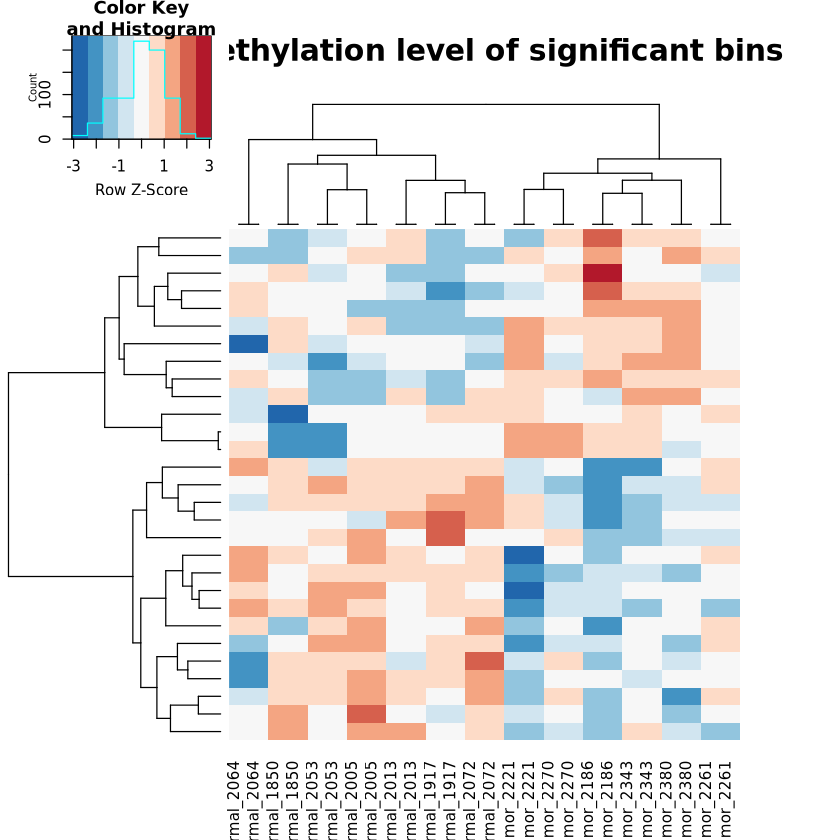

In [11]:
plotHeatMap(radar_obj)

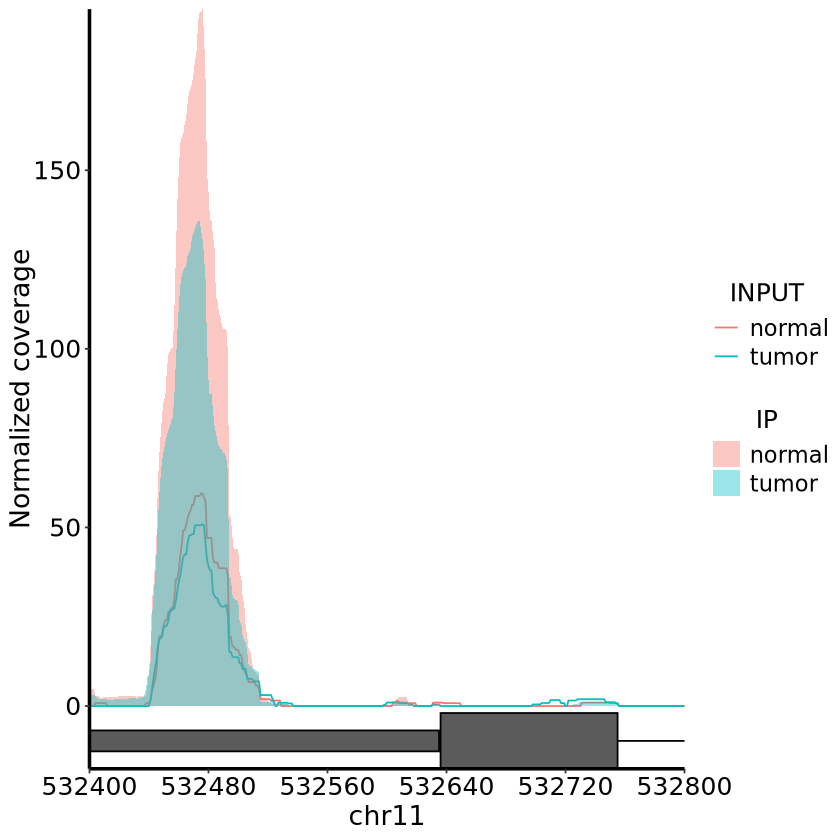

In [12]:
radar_obj <- PrepCoveragePlot(radar_obj)
plotGeneCov(radar_obj,geneName = "ENSG00000174775.18", center = median, libraryType = "opposite", ZoomIn = c(532400,532800))

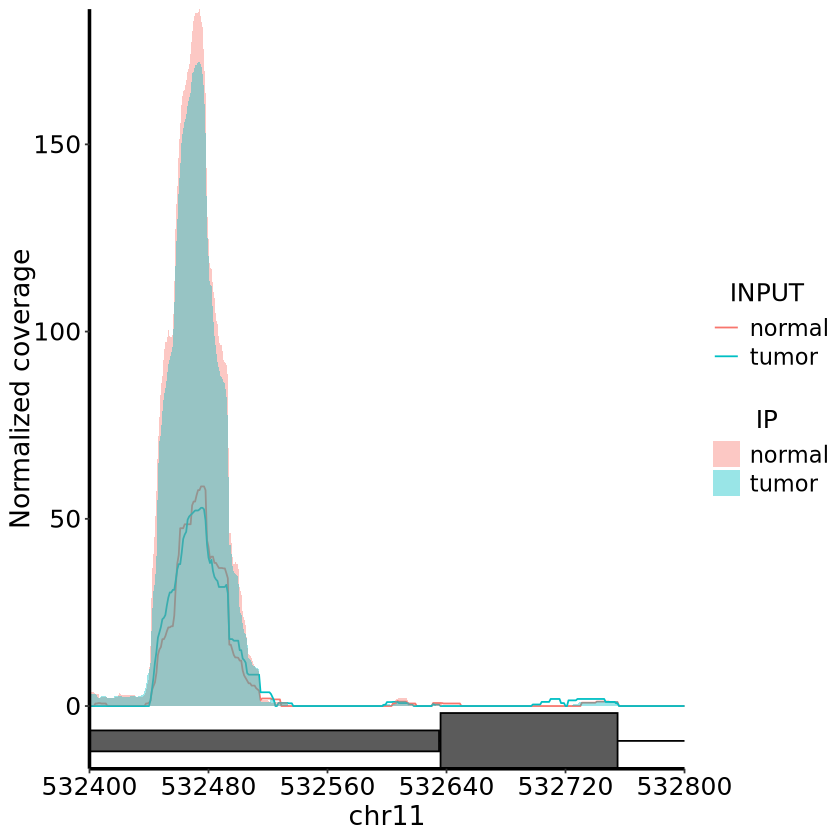

In [13]:
plotGeneCov(radar_obj,geneName = "ENSG00000174775.18", center = median, libraryType = "opposite", ZoomIn = c(532400,532800),adjustExprLevel = T )

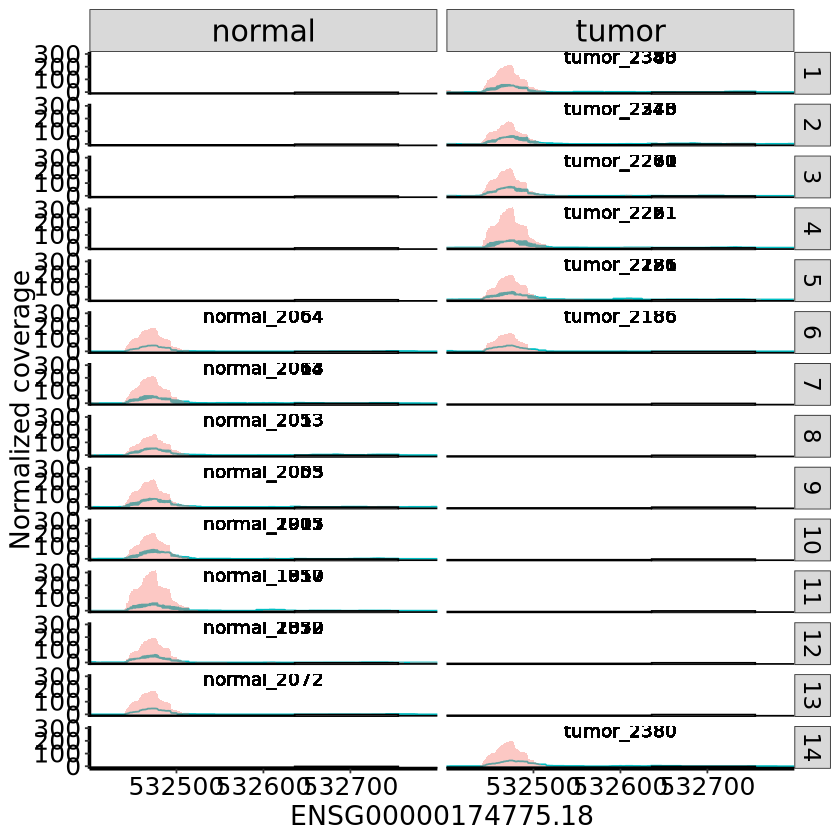

In [14]:
plotGeneCov(radar_obj,geneName = "ENSG00000174775.18", center = median, libraryType = "opposite", ZoomIn = c(532400,532800),adjustExprLevel = T,split=T )

## 4. **ExomePeak2** workflow - Peak calling + Differential 
"**exomePeak2** provides technical independent peak detection and differential methylation analysis for Methylated RNA immunoprecipitation sequencing data (MeRIP-Seq). MeRIP-Seq is the primary sequencing technology for epi-transcriptomic assessment. The peak calling processes in MeRIP-Seq is sensitive to GC content biases, which are generally present in NGS-based assays. Besides, the antibody pull-down efficiency do often vary across different IP replicates, introducing another layer of unwanted technical variation. exomePeak2 addresses these challenges by introducing a robust set of computation tools tailored for MeRIP-Seq. With exomePeak2, users can perform peak calling and differential analysis through a straightforward single-step function." - The <i>ExomePeak2</i> Guide


For this tutorial, we use human reference genome, so the package needs to be installed. If you are using different genome later, need to install the genome as well. 

In [ ]:
BiocManager::install("exomePeak2")
BiocManager::install("BSgenome.Hsapiens.UCSC.hg38")
library(exomePeak2)

In [16]:
# prepare the input files
INPUT_BAM <- meta[grepl("input", meta$sample) & meta$group == "normal", "new_bam"]
IP_BAM <- meta[grepl("IP", meta$sample) & meta$group == "normal", "new_bam"]
TREATED_INPUT_BAM <- meta[grepl("input", meta$sample) & meta$group == "tumor", "new_bam"]
TREATED_IP_BAM <- meta[grepl("IP", meta$sample) & meta$group == "tumor", "new_bam"]
GENE_ANNO_GTF <- "../Tutorial_1/gencode.v46.pri.chr11.1.5M.gtf"

### Peak calling
For peak calling in a MeRIP-Seq experiment, **exomePeak2** requires the alignment results to be provided in **BAM** format. You need to specify the **BAM** files for IP and input samples using the arguments <code>bam_ip</code> and <code>bam_input</code> in the <code>exomePeak2()</code> function.

Below is an example of how to perform peak calling using **BAM** and **GFF** files. In addition to **GFF** files, transcript annotation can also be supplied via the **TxDb** object from <code>Bioconductor</code>. If the UCSC genome name is provided in the <code>genome</code> argument, **TxDb** will be automatically downloaded.

To correct for GC content biases, the genome sequence should be specified in the <code>genome</code> argument. If no genome is provided (i.e., <code>genome = NULL</code>), **exomePeak2** will run without GC content bias correction, which may affect peak detection.

```
exomePeak2(bam_ip = IP_BAM,
           bam_input = INPUT_BAM,
           gff = GENE_ANNO_GTF,
           genome = "hg38")
```
This code identifies peaks using the IP and input BAM files from control samples. While this step is important, note that the differential analysis in **exomePeak2** automatically performs peak calling before the differential analysis step. Therefore, we will not include this step separately in the tutorial.

### Differential Methylation Analysis
In the differential analysis step, **exomePeak2** compares IP (immunoprecipitation) and input samples across the two conditions, taking into account the RNA modifications’ fold change and statistical significance. The analysis uses regions defined by transcript annotations (e.g., exons) to focus on functional genomic elements.

The following example demonstrates how to perform differential methylation analysis using the IP and input BAM files for two biological conditions using our example dataset:

In [ ]:
exomePeak2(bam_ip = IP_BAM,
           bam_input = INPUT_BAM,
           bam_input_treated = TREATED_INPUT_BAM,
           bam_ip_treated = TREATED_IP_BAM,
           gff = GENE_ANNO_GTF,
           genome = "hg38")

<div style="border: 1px solid #9ec5fe; padding: 0px; border-radius: 4px;">
    <div style="background-color: #cfe2ff; padding: 5px;">
        <i class="fas fa-file-alt" style="color: #052c65;margin-right: 5px;"></i>
        <a style="color: #052c65"><b>Notes</b>. exomePeak2 output </a>
    </div>
    <p style="margin-left: 5px;">
    Besides the <i>GRangesList</i> object of peaks returned by the main function, exomePeak2 will export significant peaks in <b>BED</b> and <b>CSV</b> format; the files will be automatically saved in a folder named <code>exomePeak2_output</code>.
    </p>
    <p style="margin-left: 5px;"><img src="images/2-GC_fit.jpg" width=400 />
    <p style="margin-left: 5px;">
The <b>GC_fit.pdf</b> output (figure above) from exomePeak2 is a diagnostic plot that visualizes the relationship between GC content and sequencing signal to assess and correct for GC content bias during peak calling. The X-axis represents the GC content of genomic regions, while the Y-axis shows the observed sequencing signal. The fitted curve on the plot indicates how exomePeak2 models and adjusts for GC bias, ensuring that methylation peaks are detected based on biological signals rather than sequencing artifacts. This figure helps confirm whether GC content bias is present and whether it has been properly corrected.
    </p>
</div>

In [ ]:
dim(radar_obj@norm.ip)
dim(radar_obj@norm.input)
head(radar_obj@norm.ip)
rownames(radar_obj@ip_adjExpr_filtered) 

## **Enrichment analysis**

In [19]:
#BiocManager::install("clusterProfiler")

#library(clusterProfiler)
#library(org.Hs.eg.db)

## Conclusion
Provide an overview of the lessons and skills learned from the module.

## Clean up
A reminder to shutdown VM and delete any relevant resources. <br><br>

<br>

### Data visualization with R
[Open R Notebook](./reference_notebooks/r_viz_template.ipynb)